# Machine Learning - the k-Nearest Neighbours Algorithm<br>

![Minecraft Steve and Creeper](data/msac.jpg)
<h1><center>Friend or foe?</center></h1>

This notebook will teach you how to create a k-Nearest Neighbours machine learning algorithm. First, we'll train the model on our images of the Minecraft mobs. Then, once the model has learned which mobs are hostile, neutral or passive, we'll test the model on some never-before seen images to see if it can tell its behaviour!

## k-Nearest Neighbours


Think about your best friend. Why do you like them? Are they funny, or kind, or athletic? Make a list in your head of all the qualities they have. Now think - do you share any of these qualities? Are **you** funny, or kind, or athletic? If you share a lot of qualities, you can think of them as your "Nearest Neighbour". The "k" in k-Nearest Neighbours is 1 in this case. If we thought about your two best friends, "k" would be 2. It simply means the number of neighbours.<br><br>Now, imagine a new kid moves to town who shares a lot of the qualities you and your friends have. Would you like to make friends with them? You might predict, "Yes! If they are like me and my best friend, we'll probably get on well". Now let's think about a similar situation for our machine learning model. If we can find some qualities that hostile Minecraft mobs share, we can look for those qualities in a new mob and predict if they're dangerous or not!


## Start here: How to use this notebook

Each box below contains some code we're going to run. We want to run each cell in order to make sure everything works. Try clicking on the box below. You should see a green outline appear around it. To run the code in the box, click the run button at the top of the page. Or, you can hold the shift key and press Enter. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import cv2 as cv
import random
from pathlib import Path
from sklearn import neighbors
%matplotlib inline
print("All libraries Loaded!")

All libraries Loaded!


If you see the `All libraries loaded!` message below the box, you've done it correctly - well done! Don't worry too much about the code in the box. We use it to load some extra code that will be working behind the scenes to assist us. <br><br>Try running the code in the box below.

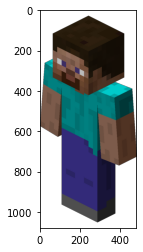

In [2]:
minecraft_steve = plt.imread("data/minecraft_steve.png") # this line loads a picture
plt.imshow(minecraft_steve) # this line shows the picture 

You should now see a picture of Steve. Note the sentences following the `#` symbols - we use this method to add handy notes which explain what is going on in a particular piece of code.

You're all set now! Let's get stuck in. Run each box of code in order. You can be sure it is a code box if you see `In [ ]:` to the left of the box. When you see `In [*]:` with the `*` in the brackets, it means the code is running. It might take a little bit of time to run all the code so don't worry if it's taking a long time!

## Who do I look most like? 

To compare images, we need to understand how the computer looks at them. Run the code box below.

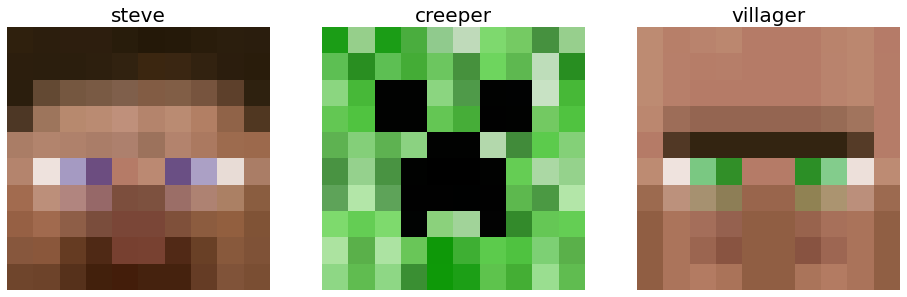

In [3]:
character_names = ["steve", "creeper", "villager"] 
character_faces = [plt.imread("data/" + name + ".png") for name in character_names]
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize = (16,16))
for ax, face, label in zip(fig.axes, character_faces, character_names):
    ax.imshow(face)
    ax.axis('off')
    ax.set_title(label, fontsize=20)

You should now see 3 faces. Each face is made up of 100 individual coloured squares called "pixels". By combining green pixels and black pixels in a certain order, we can construct its face. Steve's face on the left is also made up of 100 pixels, but they are of different colours. <br><br>The third face on the right belongs to a villager. Do you think it is more similar to the creeper, or to Steve? You can probably guess, but can we help the computer to decide?<br><br>Well, each pixel has 3 numbers which tell us how strong the red, green and blue colours are for that individual pixel square. For example, the creeper has some really strong green pixel numbers, but almost zero red or blue pixel numbers. We can compare these numbers to determine how similar the images are!

In [4]:
how_similar_to_steve = np.sum(abs(character_faces[0] - character_faces[2])) 
how_similar_to_creeper = np.sum(abs(character_faces[1] - character_faces[2]))
nearest_neighbour = min(how_similar_to_steve, how_similar_to_creeper)
print(f"Distance from Steve is {int(how_similar_to_steve)}. Distance from Creeper is {int(how_similar_to_creeper)}."
      f" Nearest neighbour is Steve!")

Distance from Steve is 64. Distance from Creeper is 83. Nearest neighbour is Steve!


All we have done here is subtract the pixel numbers of the villager from both Steve and the creeper. The smaller the value of the distance is, the more similar the pixels contained in that image are. But instead of "Steveiness" and "Creepiness", we want our model to figure out whether a photo you give is contains a mob that is hostile, neutral or passive. And, instead of using three photos to decide, we're going to use the power of computers to test thousands! Let's load all of our images.

In [5]:
def LoadImageFiles(image_storage_path):
# Block 1
    image_storage_folder = Path(image_storage_path)
    folders = [directory for directory in image_storage_folder.iterdir() if directory.is_dir()]
    categories = [folder.name for folder in folders]
    
#Block 2
    image_array = []
    for folder in folders:
        for file in folder.iterdir():
            image = cv.imread(str(file))
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            image = cv.resize(image, (50, 50), interpolation=cv.INTER_AREA) / 255
            image_array.append(image)
    image_array = np.array(image_array)
    return image_array, categories


#Block 3
def ResizeImages(image_array):
    image_array = image_array.reshape(len(image_array), 50*50)
    return image_array

Don't worry if this code looks more complicated than last time; let's try and understand what each block is doing for now. `#Block 1` finds where our image folders are and reads their names out. `#Block 2` goes through every image in the folder and loads it to our program. We convert the image to gray and make it smaller to help our program run even faster. `#Block 3` finally flattens all the pixels into a big list of pixel values for each image and spits it back out. Think of it like a shopping list where each line has only one item you need. Run the code below to flatten the creeper and see what I'm talking about!

Text(0.5, 1.0, 'flat creeper')

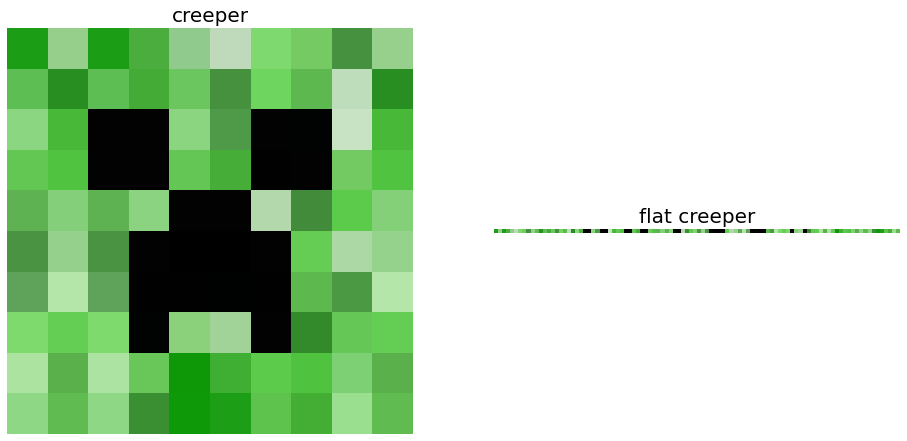

In [6]:
fig, [ax4, ax5] = plt.subplots(nrows=1, ncols=2, figsize = (16,16))
ax4.imshow(character_faces[1])
ax4.axis('off')
ax4.set_title('creeper', fontsize=20)
ax5.imshow(character_faces[1].flatten().reshape(1, 100, 3))
ax5.axis('off')
ax5.set_title('flat creeper', fontsize=20)


The very top line, `def LoadImageFiles(container_path):` is kind of like the name of this block of code. We can call its name `LoadImageFiles` in another code box and give it the location of some images saved to our computer, and it will automatically run through all the code and load the images without having to write everything out again! Pretty handy! The same goes for `def ResizeImages(image_array):` in Block 3. Let's do that again for another useful function.


In [7]:
def LabelsToNumbers(image_folder, labels):
    for i, behaviour in enumerate(labels):
        directory = image_folder + '/' + behaviour
        label_array = np.full(len([name for name in os.listdir(directory)]), i, dtype = 'int')
        if i == 0:
            labels_as_numbers = label_array
        else:
            labels_as_numbers = np.append(labels_as_numbers, label_array)
    return labels_as_numbers

`LabelsToNumbers` is doing exactly what it says. Our labels for each kind of mob are `['hostile', 'neutral', 'passive']`. Computers find it harder to read words than they do to read numbers, so we simply swap each label for a number `[0, 1, 2]` where hostile is 0, neutral is 1 and passive is 2. This lets our program run much faster!

Now, let's use our functions we just wrote to load all our images, and turn their labels into numbers.

Images Loaded Successfully!


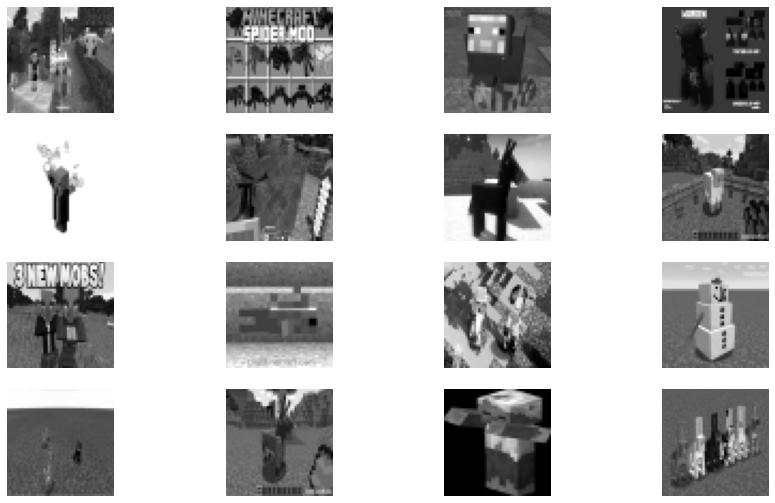

In [8]:
# Load images to train with #
training_image_folder = "images/Images to Train With"
images, labels = LoadImageFiles(training_image_folder)
images_flattened = ResizeImages(images)
labels_as_numbers = LabelsToNumbers(training_image_folder, labels)

# Load images to test with #
testing_image_folder = "images/Images to Test With"
test_images, test_labels = LoadImageFiles(testing_image_folder)
test_images_flattened = ResizeImages(test_images)
test_labels_as_numbers = LabelsToNumbers(testing_image_folder, test_labels)

print("Images Loaded Successfully!")

# Show some random images #
plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_image = random.choice(images)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(random_image, cmap = 'gray')
plt.show()

See any mobs you recognise? Remember we loaded all the images as gray and made them smaller!<br><br>Now, let's return to thinking about the nearest neighbours. Remember when we subtracted the images previously to determine their distances from each other? That's not the only way of determining how similar images are. We will use the dreaded (and extremely useful) Pythagoras's Theorem to measure this instead. So if you're bored learning about it in math class, remember it can be used to teach computers how to think!<br><br>We've loaded in our training images, like we loaded the pictures of Steve and the Creeper. We've loaded in our testing image, like we loaded the picture of the villager. Now, instead of testing just one image, we're going to calculate the nearest neighbor for every single image and see how many times it guesses right! 

In [21]:
for i in range (1,10):
    knn = neighbors.KNeighborsClassifier(n_neighbors = i)
    print(f'For k = {i}, KNN score is {int(len(test_images)*(knn.fit(images_flattened, labels_as_numbers).score(test_images_flattened, test_labels_as_numbers)))} / {len(test_images)} ({100*knn.fit(images_flattened, labels_as_numbers).score(test_images_flattened, test_labels_as_numbers):.1f}% accuracy)')

For k = 1, KNN score is 1567 / 3264 (48.0% accuracy)
For k = 2, KNN score is 1407 / 3264 (43.1% accuracy)
For k = 3, KNN score is 1402 / 3264 (43.0% accuracy)
For k = 4, KNN score is 1389 / 3264 (42.6% accuracy)
For k = 5, KNN score is 1414 / 3264 (43.3% accuracy)
For k = 6, KNN score is 1416 / 3264 (43.4% accuracy)
For k = 7, KNN score is 1416 / 3264 (43.4% accuracy)
For k = 8, KNN score is 1401 / 3264 (42.9% accuracy)
For k = 9, KNN score is 1421 / 3264 (43.5% accuracy)


So when k = 1, we have our best prediction with almost one half correct! This might not seem like a lot, but if we were to randomly guess which mob belonged to which class, we expect our accuracy to be 33% or one third. 

## How to improve our results

One way to improve our results would be to look at the images in color and factor that when calculating distance of neighbors. 
However, k-Nearest Neighbours *does not actually learn*. It's more like if you wrote all the answers down for a test and looked at your page for the answers, instead of figuring out the answer on your own. It's also not the best method for classifying images like ours with text, weird graphics and other random things that aren't mobs: It gets a little confused. If you want to see some code that learns and improves in accuracy, check out the "Hard Mode" tutorial to learn about Convolutional Neural Networks and see some really powerful predictions!!

![Minecraft Steve dance](data/stevedance.gif)
<h1><center>Thanks for playing!</center></h1>

# Get your certificate here!

What is your name? Type it in here: William McIlwain
William McIlwain
Right click and select, "Save image as..." to save your certificate


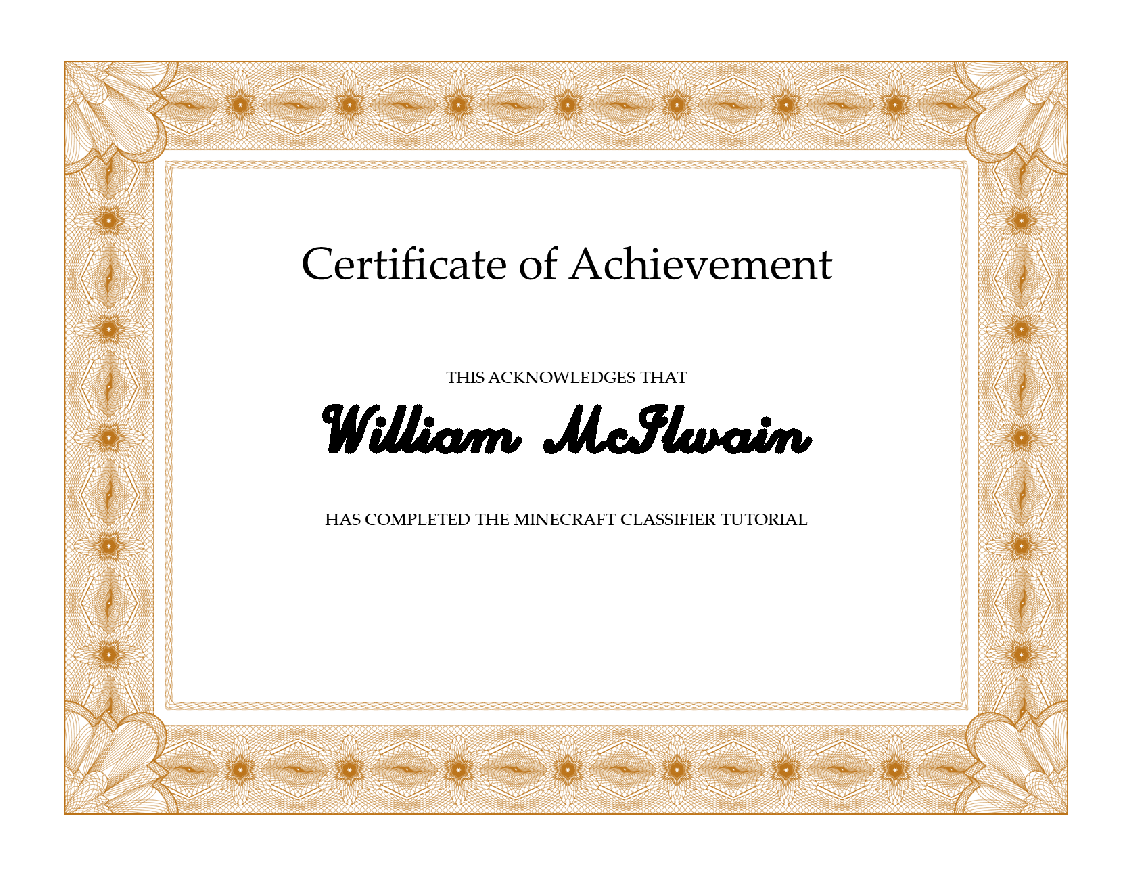

In [31]:
import cv2 as cv
import matplotlib.pyplot as plt
import calendar

template_path = 'data/certificate.png'
output_path = '/.'
font_size = 3
font_color = (0,0,0)
coordinate_y_adjustment = 15
coordinate_x_adjustment = 7

name = input("What is your name? Type it in here: ")

img = cv.imread(template_path)
font = cv.FONT_HERSHEY_SCRIPT_COMPLEX
text_size = cv.getTextSize(name, font, font_size, 10)[0]
text_x = (img.shape[1] - text_size[0]) / 2 + coordinate_x_adjustment
text_y = (img.shape[0] + text_size[1]) / 2 - coordinate_y_adjustment
text_x = int(text_x)
text_y = int(text_y)
cv.putText(img, name,
    (text_x ,text_y ),
    font,
    font_size,
    font_color, 10)


plt.figure(figsize = (20,20))
plt.imshow(img, interpolation='nearest')
plt.axis("off")
print("Right click and select, \"Save image as...\" to save your certificate")